In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)


Mounted at /content/drive


In [2]:
# install syft
!pip install syft==0.2.9

     |████████████████████████████████| 440kB 5.6MB/s 
     |████████████████████████████████| 491kB 40.6MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 20.1MB 1.2MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 4.0MB 16.3MB/s 
     |████████████████████████████████| 71kB 6.9MB/s 
     |████████████████████████████████| 753.4MB 19kB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 2.0MB 28.8MB/s 
     |████████████████████████████████| 204kB 42.8MB/s 
     |████████████████████████████████| 450kB 46.9MB/s 
     |████████████████████████████████| 133kB 44.7MB/s 
     |████████████████████████████████| 1.8MB 14.8MB/s 
     |████████████████████████████████| 9.0MB 2.2MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |██

In [3]:
# install private set intersection 
# to encrypt raw data
!pip install openmined.psi

     |████████████████████████████████| 1.9MB 5.7MB/s 


In [5]:
import tensorflow as tf
import sys

# import the module from google drive
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')
import src


import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import TensorDataset
from torchvision.transforms import ToTensor

import syft as sy

hook = sy.TorchHook(torch)

In [6]:
from src.dataloader import VerticalDataLoader
from src.psi.util import Client, Server
from src.utils.split_data import add_ids

In [7]:
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [8]:
from uuid import uuid4

import numpy as np
import pandas as pd

import time
import matplotlib.pyplot as plt

In [39]:
# load the data
df = pd.read_csv("drive/MyDrive/Colab Notebooks/data/dataset_a_all.csv")

In [40]:
# clean the data
# transform into binary columns

df = df.dropna()
df = pd.get_dummies(df)
cols = df.columns.tolist()
cols.remove('Indicators')
cols.append('Indicators')
df = df[cols]
df.head()

,Applied Loan Amount,Applied Loan Tenor,Gender,Age,Monthly Housing/Rental,Monthly Income,Education Level_Form 3 or below,Education Level_No Response,Education Level_Post Graduate,Education Level_Post Secondary,Education Level_Primary,Education Level_Secondary,Education Level_University,Indicators
0,60000,24,1,22.301,0.0,10245.0,0,0,0,0,0,1,0,0
1,100000,60,1,33.159,0.0,10000.0,1,0,0,0,0,0,0,0
2,50000,24,0,28.389,2000.0,9700.0,0,0,0,0,0,0,1,0
3,70000,36,1,35.573,1200.0,23000.0,0,0,1,0,0,0,0,0
4,300000,60,0,30.849,11000.0,34000.0,0,0,0,0,0,0,1,0


In [41]:
# split it into training and testing dataset
train, test = train_test_split( df , test_size=0.3, random_state=42)

In [42]:
# Dataset A setting
# cols = ["Applied Loan Amount", 'Applied Loan Tenor', "Age", "Monthly Income", 'Monthly Housing/Rental', "Final_Status (Y/N)"]
# train = train[cols]
train.shape

(8168, 14)

In [43]:
# test = test[cols]
test.shape

(3501, 14)

In [44]:
# transform into tensor data
train_features = torch.as_tensor(train.drop("Indicators", axis=1).to_numpy()) # can only from numpy to tensor
train_target = torch.as_tensor(train["Indicators"].to_numpy())

In [45]:
# transform into tensor data
test_features = torch.as_tensor(train.drop("Indicators", axis=1).to_numpy()) # can only from numpy to tensor
test_target = torch.as_tensor(train["Indicators"].to_numpy())

In [46]:
# Implements a vertical dataset with TensorDataset
import torch
from torch.utils.data import Dataset
device = 'cpu'
print(device)

cpu


In [47]:
# self-designed VerticalTensorDataset
# to add id, set features and target

class VerticalTensorDataset(Dataset):
    def __init__(self, features, targets):
        super().__init__()

        self.data = features
        self.targets = targets
        self.size = features.shape[0]

        self.ids = np.array([uuid4() for _ in range(len(self))])

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        if self.data is None:
          data = None
        else:
          data = self.data[index]
        if self.targets is None:
          target = None
        else:
          target = self.targets[index]

        id = self.ids[index]

        return (*filter(lambda x: x is not None, (data, target, id)),)

    def get_ids(self):
        return [str(id) for id in self.ids]
    


In [48]:
# put training data into VerticalTensorDataset 
# to add ids and identify features and target column
train_dataset = VerticalTensorDataset(train_features, train_target)

print(train_dataset[0])
# VerticalDataLoader is from PyVertical package
# it vetically patitions the data
train_dataloader = VerticalDataLoader(train_dataset, batch_size = 64) 

(tensor([3.0000e+06, 6.0000e+01, 1.0000e+00, 4.4660e+01, 0.0000e+00, 2.5000e+05,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64), tensor(0), UUID('e43e77f5-1685-44fb-8f65-1891195c5847'))


In [49]:
# apply on testing data
test_dataset = VerticalTensorDataset(test_features, test_target)

print(test_dataset[0])

test_dataloader = VerticalDataLoader(test_dataset, batch_size = 1)

(tensor([3.0000e+06, 6.0000e+01, 1.0000e+00, 4.4660e+01, 0.0000e+00, 2.5000e+05,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64), tensor(0), UUID('b072a338-ed53-4598-83de-77b395ac07ef'))


In [50]:
# SplitNN
# assign model segments to each local nodes
# define how gradient is sent
class SplitNN:
    def __init__(self, models, optimizers):
        self.models = models
        self.optimizers = optimizers

        self.data = []
        self.remote_tensors = []

    def forward(self, x):
        data = []
        remote_tensors = []

        data.append(self.models[0](x))

        if data[-1].location == self.models[1].location:
            remote_tensors.append(data[-1].detach().requires_grad_())
        else:
            remote_tensors.append(
                data[-1].detach().move(self.models[1].location).requires_grad_()
            )

        i = 1
        while i < (len(models) - 1):
            data.append(self.models[i](remote_tensors[-1]))

            if data[-1].location == self.models[i + 1].location:
                remote_tensors.append(data[-1].detach().requires_grad_())
            else:
                remote_tensors.append(
                    data[-1].detach().move(self.models[i + 1].location).requires_grad_()
                )

            i += 1

        data.append(self.models[i](remote_tensors[-1]))

        self.data = data
        self.remote_tensors = remote_tensors

        return data[-1]
        
    def backward(self):
        for i in range(len(models) - 2, -1, -1):
            if self.remote_tensors[i].location == self.data[i].location:
                grads = self.remote_tensors[i].grad.copy()
            else:
                grads = self.remote_tensors[i].grad.copy().move(self.data[i].location)
    
            self.data[i].backward(grads)

    def zero_grads(self):
        for opt in self.optimizers:
            opt.zero_grad()

    def step(self):
        for opt in self.optimizers:
            opt.step()

In [51]:
torch.manual_seed(3)

# Define our model segments

input_size = 13
hidden_sizes = [32, 64]
output_size = 1


# Deep Learning model
# to apply it in SplitNN framework, it is divided into 2 parts
models = [
    nn.Sequential(
        nn.Linear(input_size, hidden_sizes[0]),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_sizes[0]),
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_sizes[1]),
        nn.Dropout(p=0.1)
    ),
    nn.Sequential(nn.Linear(hidden_sizes[1], output_size))

]
'''
models = [
    nn.Sequential(
        nn.Linear(input_size, hidden_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        nn.ReLU(),
        nn.Dropout(p=0.1)
    ),
    nn.Sequential(nn.Linear(hidden_sizes[1], output_size))

]
'''
# create optimisers for each segment and link to them
optimizers = [
    optim.SGD(model.parameters(), lr=0.001)
    for model in models
]


In [52]:
# create virtual workers as local node simulation
alice = sy.VirtualWorker(hook, id="alice")
bob = sy.VirtualWorker(hook, id="bob")

# send Model Segments to model locations
model_locations = [alice, bob]
for model, location in zip(models, model_locations):
    model.send(location)

# instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = SplitNN(models, optimizers)

In [53]:
def train(x, target, splitNN):
    
    #1) Zero our grads
    splitNN.zero_grads()
    
    #2) Make a prediction
    pred = splitNN.forward(x)
    
    #3) Figure out how much we missed by
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(pred.reshape(-1), target.to(torch.float))
    
    #4) Backprop the loss on the end layer
    loss.backward()
    
    #5) Feed Gradients backward through the nework
    splitNN.backward()
    
    #6) Change the weights
    splitNN.step()
    
    return loss, pred

In [54]:
epochs = 100

In [55]:
e_loss = []
e_acc = []
timelist = []

In [56]:
for i in range(epochs):
    running_loss = 0
    correct_preds = 0
    total_preds = 0
    epoch_loss = 0
    epoch_acc = 0
    start_time = time.time()

    for (data, ids1), (labels, ids2) in train_dataloader:
        # Train a model
        data = data.send(models[0].location)
        data = data.view(data.shape[0], -1)
        labels = labels.send(models[-1].location)

        # Call model
        loss, preds = train(data.float(), labels, splitNN)
        
        # Convert predictions
        preds_ = preds.get().squeeze(1)
        labels_ = labels.get()
        preds_match = ((torch.sigmoid(preds_) > 0.5) == labels_)
        #print(non_exist)

        # Collect statistics
        running_loss += loss.get()
        correct_preds = correct_preds + int(preds_match.sum())
        total_preds = total_preds + int(preds_match.size()[0])

    total_time = time.time() - start_time
    timelist.append(total_time)
    e_loss.append((running_loss/len(train_dataloader)).item()) # for plt
    e_acc.append((100*correct_preds/total_preds)) # for plt

    print(f"Epoch {i} - Training loss: {running_loss/len(train_dataloader):.3f} - Accuracy: {100*correct_preds/total_preds:.3f}")

Epoch 0 - Training loss: 0.721 - Accuracy: 49.755
Epoch 1 - Training loss: 0.711 - Accuracy: 50.661
Epoch 2 - Training loss: 0.705 - Accuracy: 49.804
Epoch 3 - Training loss: 0.703 - Accuracy: 50.147
Epoch 4 - Training loss: 0.701 - Accuracy: 50.796
Epoch 5 - Training loss: 0.698 - Accuracy: 51.922
Epoch 6 - Training loss: 0.698 - Accuracy: 51.714
Epoch 7 - Training loss: 0.697 - Accuracy: 51.849
Epoch 8 - Training loss: 0.697 - Accuracy: 51.836
Epoch 9 - Training loss: 0.696 - Accuracy: 51.836
Epoch 10 - Training loss: 0.696 - Accuracy: 51.983
Epoch 11 - Training loss: 0.697 - Accuracy: 52.143
Epoch 12 - Training loss: 0.694 - Accuracy: 52.534
Epoch 13 - Training loss: 0.695 - Accuracy: 52.755
Epoch 14 - Training loss: 0.695 - Accuracy: 51.824
Epoch 15 - Training loss: 0.694 - Accuracy: 52.522
Epoch 16 - Training loss: 0.693 - Accuracy: 53.146
Epoch 17 - Training loss: 0.694 - Accuracy: 52.951
Epoch 18 - Training loss: 0.693 - Accuracy: 52.595
Epoch 19 - Training loss: 0.693 - Accurac

In [57]:
preds_match

tensor([False, False, False,  True,  True,  True, False,  True,  True, False,
        False,  True,  True,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True,  True,  True,  True,  True, False, False,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True])

In [58]:
print("Labels pointing to: ", labels)
print("Data pointing to: ", data)

Labels pointing to:  

AttributeError: ignored

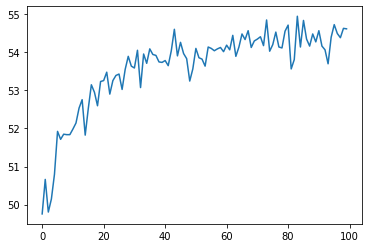

In [59]:
plt.plot(e_acc)

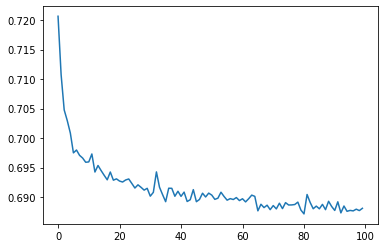

In [60]:
plt.plot(e_loss)

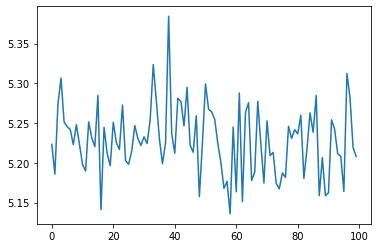

In [61]:
plt.plot(timelist)

In [63]:
import statistics
x = statistics.mean(timelist)
print(x)

5.228355464935302


In [64]:
# define test to apply trained model
def test(x, target, splitNN):
       
    #1) Make a prediction
    pred = splitNN.forward(x)
    
    #2) Figure out how much we missed by
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(pred.reshape(-1), target.to(torch.float))
        
    return loss, pred

In [65]:
y_pred_list = []
y_target_list = []
running_loss = 0
correct_preds = 0
total_preds = 0

# lock the models
models[0].eval()
models[1].eval()

# put testing data into the models

with torch.no_grad():
    for (data, ids1), (labels, ids2) in test_dataloader:
        # Train a model
        data = data.send(models[0].location)
        data = data.view(data.shape[0], -1)
        labels = labels.send(models[-1].location)

        # Call model
        loss, preds = test(data.float(), labels, splitNN)
        
        # Convert predictions
        preds_ = preds.get().squeeze(1)
        labels_ = labels.get()
        preds_match = ((torch.sigmoid(preds_) > 0.5) == labels_)
        y_pred_list.append(torch.sigmoid(preds_) > 0.5)
        y_target_list.append(labels_)

        # Collect statistics
        running_loss += loss.get()
        correct_preds = correct_preds + int(preds_match.sum())
        total_preds = total_preds + int(preds_match.size()[0])


    print(f" Testing loss: {running_loss/len(test_dataloader):.3f} - Accuracy: {100*correct_preds/total_preds:.3f}")

 Testing loss: 0.697 - Accuracy: 54.150


In [66]:
print(y_pred_list[0:10])
print(y_target_list[0:10])

[tensor([False]), tensor([False]), tensor([False]), tensor([False]), tensor([False]), tensor([False]), tensor([False]), tensor([False]), tensor([False]), tensor([False])]
[tensor([0]), tensor([1]), tensor([1]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([1]), tensor([1]), tensor([0])]


In [67]:
confusion_matrix(y_target_list, y_pred_list)

array([[4367,   54],
       [3691,   56]])

In [68]:
print(classification_report(y_target_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.54      0.99      0.70      4421
           1       0.51      0.01      0.03      3747

    accuracy                           0.54      8168
   macro avg       0.53      0.50      0.36      8168
weighted avg       0.53      0.54      0.39      8168

